In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

# Вероятностный латентный семантический анализ

Посмотрим применение `EM`-алгоритма для определнения тем, которые чаше всего раскрываются в фильмах опубликованных на [Netflix](https://www.kaggle.com/shivamb/netflix-shows).

### Чтение данных

Прочитаем таблицу `Netflix.csv` и возьмём только строки с описанием фильмов, у которых есть текстовое описание.

In [2]:
table = pd.read_csv('netflix_titles.csv', index_col=0)
table = table[table['type'] == 'Movie']
table = table[table['description'].notna()]

table.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...


### Векторизация текста

С помощью [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) векторизуем описания фильмов

In [3]:
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
X = vectorizer.fit_transform(table['description'])

X = pd.DataFrame(X.toarray(), columns=vectorizer.vocabulary_, index=table.index).T
X.head(3)

show_id,s1,s7,s8,s10,s13,s14,s17,s19,s23,s24,...,s8793,s8794,s8795,s8799,s8800,s8802,s8803,s8805,s8806,s8807
as,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
her,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
father,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Реализация EM алгоритма

Реализуем класс `PLSA`, который наследуется от [sklearn.base.TransformerMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html) и имеет аргументы `num_topics` и `num_iter`.

Оценить, насколько хорошей получилась модель по существующим данным, можно с помощью перплексии. Это мера несоответствия модели словам $w$, наблюдаемым в документах $d$.
$$Perp = \exp\left(\frac{1}{n}\ell_X(\theta, \varphi)\right)$$

In [4]:
class PLSA(TransformerMixin):
    def __init__(self, num_topics=10, num_iter=20):
        '''
        Инициализация класса PLSA.
        num_topics -- количество тем
        num_iter -- количество итераций EM-алгоритма
        '''
        
        self.num_topics = num_topics
        self.topic_names = [f'topic_{index}' for index in range(num_topics)]
        self.num_iter = num_iter
        
        
    def initialization(self, vocabulary, doc_names):
        '''
        Инициализация параметров случайными значениями согласно распределению Дирихле.
        vocabulary -- словарь
        doc_names -- имена документов
        '''
        
        # Phi (W x T)
        self.Phi = np.random.dirichlet(np.ones(self.num_topics), size=len(vocabulary))
        self.Phi = pd.DataFrame(self.Phi, index=vocabulary, columns=self.topic_names)
        
        # Theta (T x D)
        self.Theta = np.random.dirichlet(np.ones(len(doc_names)), size=self.num_topics)
        self.Theta = pd.DataFrame(self.Theta, index=self.topic_names, columns=doc_names)
        
        # gamma (T x W x D)
        self.gamma = np.ones((self.num_topics, len(vocabulary), len(doc_names))) / self.num_topics
        
        
    def E_step(self, X):
        '''
        Реализация E-шага в PLSA.
        X -- pandas-таблица количества каждого слова в документе, размер W x D
        '''
        
        divider = self.Phi @ self.Theta
        for t in range(self.num_topics):
            phi = self.Phi.values[:, t, np.newaxis]
            theta = self.Theta.values[t, np.newaxis, :]
            self.gamma[t] = phi@theta / divider
        
    
    def M_step(self, X):
        '''
        Реализация M-шага в PLSA.
        X -- pandas-таблица количества каждого слова в документе, размер W x D
        '''

        self.Phi = []
        self.Theta = []

        for t in range(self.num_topics):
            X_gamma = X * self.gamma[t]
            
            phi = X_gamma.sum(axis=1)
            phi.rename(self.topic_names[t], inplace=True)
            self.Phi.append(phi)
            
            theta = X_gamma.sum(axis=0)
            theta.rename(self.topic_names[t], inplace=True)
            self.Theta.append(theta)

        # Нормировки
        
        self.Phi = pd.concat(self.Phi, axis=1)
        self.Phi /= self.Phi.sum(axis=0)

        self.Theta = pd.concat(self.Theta, axis=1).T
        self.Theta /= self.Theta.sum(axis=0)
        
        
    def elbo(self, X):
        '''
        Вычисление функционала качества -- нижняя оценка на логарифм правдоподобия.
        X -- pandas-таблица количества каждого слова в документе, размер W x D
        '''
        
        return (
            self.gamma * (np.log(self.Phi.values.T[:, :, np.newaxis]) \
                          + np.log(self.Theta.values[:, np.newaxis, :])) \
            * X.values[np.newaxis, :, :]
        ).sum() - (
            self.gamma * np.log(self.gamma) * X.values[np.newaxis, :, :]
        ).sum()
        
        
        
    def perplexity(self, X):
        '''
        Вычисление перплексии.
        X -- pandas-таблица количества каждого слова в документе, размер W x D
        '''
        
        score = (X * np.log(self.Phi @ self.Theta)).values.sum()
        score /= X.values.sum()
        
        return np.exp(-score)
    
    
    def fit(self, X):
        '''
        Итерации EM-алгоритма.
        X -- pandas-таблица количества каждого слова в документе, размер W x D
        '''
        
        self.initialization(X.index, X.columns)
        
        self.scores = {'perplexity': [self.perplexity(X)], 'elbo': [self.elbo(X)]}
        for _ in tqdm(range(self.num_iter), desc='Итерации EM'):
            self.E_step(X)
            self.scores['perplexity'].append(self.perplexity(X))
            self.scores['elbo'].append(self.elbo(X))
            self.M_step(X)
            self.scores['elbo'].append(self.elbo(X))
            
        return self

Обучим модель, проведя 20 эпох ЕМ алгоритма

In [5]:
model = PLSA().fit(X)

Итерации EM: 100%|██████████| 20/20 [11:07<00:00, 33.37s/it]


Посмотрим на ELBO и на перплексию в зависимости от итераций

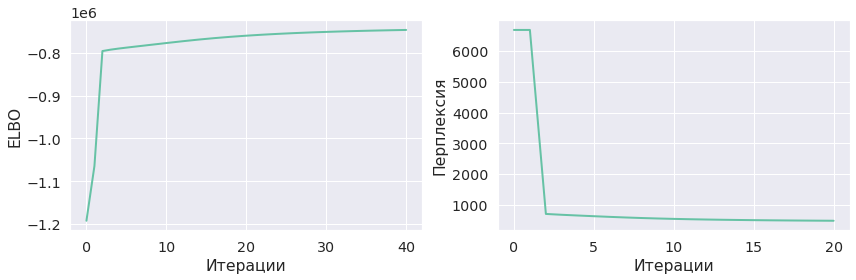

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(model.scores['elbo'], lw=2)
plt.ylabel('ELBO')
plt.xlabel('Итерации')
plt.subplot(122)
plt.plot(model.scores['perplexity'], lw=2)
plt.ylabel('Перплексия')
plt.xlabel('Итерации')
plt.tight_layout()
plt.show()

### Анализ полученного разложения

Визуализируем матрицу `Theta`, предварительно сгрупируйте документы по преобладающей теме &mdash; это нужно для наглядности.

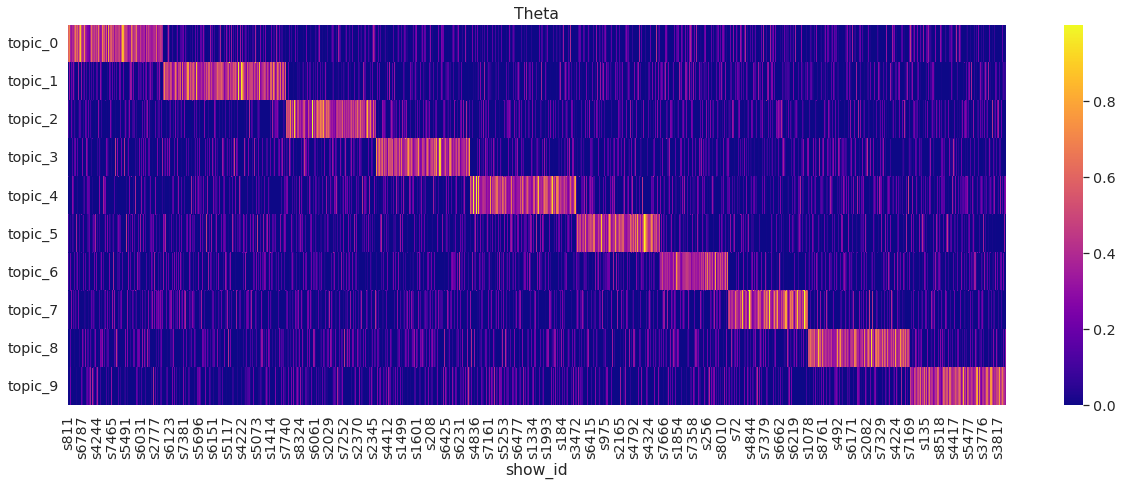

In [7]:
doc_topics = model.Theta.idxmax().sort_values()
sort_Theta = model.Theta[doc_topics.index]

plt.figure(figsize=(21, 7))
plt.title('Theta')
sns.heatmap(sort_Theta, cmap='plasma')
plt.show()

Для каждой темы напечатаем топ-10 слов темы

In [8]:
N = 10
topic_tokens = {
    topic: phi.sort_values(ascending=False).index[:N].tolist() 
    for topic, phi in model.Phi.iteritems()
}

for topic, tokens in topic_tokens.items():
    tokens = '; '.join(tokens)
    print(f'{topic}: {tokens}')

topic_0: matriarch; quite; alien; enter; acts; mend; bound; intrigue; undergoes; bumbling
topic_1: enter; matriarch; quite; bound; mend; alien; fatal; bumbling; disgruntled; entangled
topic_2: natural; form; quite; matriarch; kid; alien; silence; know; vicious; thought
topic_3: intrigue; kid; alien; doll; movement; matriarch; ravaged; accidentally; community; reunion
topic_4: natural; enter; pocoyo; disgruntled; goa; reunion; intrigue; fly; bullies; alien
topic_5: alien; doll; police; mend; reunion; western; dave; kid; dealers; chase
topic_6: for; pocoyo; alien; plus; natural; enter; police; kid; community; bruce
topic_7: matriarch; quite; alien; pocoyo; bruce; evolution; reunion; fatal; natural; lose
topic_8: intrigue; disgruntled; silence; thought; kid; reunion; bullies; community; seemingly; card
topic_9: intrigue; know; enter; pocoyo; quite; disgruntled; silence; alien; nephew; doll


### Недостатки PLSA

* В базовом варианте имеется медленная сходимость на больших коллекциях;
* Не выделяет нетематические слова. В реальном тексте приличествуют термины, которые не относятся явно ни к одной из тем. 
* Не позволяет управлять разреженностью, то есть если имеется много нулевых вероятностей.